# Wikipedia edits analysis

In [1]:
import pandas as pd
from pandasql import sqldf
from matplotlib import pyplot as plt


pysqldf = lambda q: sqldf(q, globals())

## Database overview

There are provided types of columns, examples of rows and general statistics for understanding data we are working with.

In [37]:
db = pd.read_csv('smallwikipedia.csv', sep=';')

db = db.convert_dtypes()
db['Datetime'] = pd.to_datetime(db['Date'])
db['Date'] = pd.to_datetime(db['Datetime'].dt.date)
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   User      998 non-null    string        
 1   Name      998 non-null    string        
 2   Date      998 non-null    datetime64[ns]
 3   changes   998 non-null    Int64         
 4   Datetime  998 non-null    datetime64[ns]
dtypes: Int64(1), datetime64[ns](2), string(2)
memory usage: 40.1 KB


In [63]:
pysqldf('''
    SELECT *
    FROM db
    LIMIT 10;
''')

,User,Name,Date,changes,Datetime
0,194.210.1.51,Bonnet_phrygien,2004-10-19 00:00:00.000000,163,2004-10-19 11:02:00.000000
1,Ske,Bonnet_phrygien,2004-10-19 00:00:00.000000,751,2004-10-19 12:11:00.000000
2,Ske,Bonnet_phrygien,2004-10-19 00:00:00.000000,17,2004-10-19 12:12:00.000000
3,83.27.202.42,Bonnet_phrygien,2004-10-21 00:00:00.000000,42,2004-10-21 10:39:00.000000
4,Med,Bonnet_phrygien,2004-10-29 00:00:00.000000,24,2004-10-29 11:06:00.000000
5,Martin.komunide.com,Ci-devant,2004-09-11 00:00:00.000000,71,2004-09-11 12:37:00.000000
6,Aoineko,Ci-devant,2004-10-11 00:00:00.000000,44,2004-10-11 05:02:00.000000
7,Sam Hocevar,Bonnet_phrygien,2004-11-28 00:00:00.000000,4,2004-11-28 02:42:00.000000
8,Cham,Ci-devant,2004-12-15 00:00:00.000000,21,2004-12-15 07:59:00.000000
9,Sfrancois,Bonnet_phrygien,2004-12-16 00:00:00.000000,35,2004-12-16 11:26:00.000000


### Pearson coefficient

We will count the Pearson correlation coefficient number changes and number of web-pages that were changed for each person. As one can suppose, the number of changed articles has a linear dependence with whole number of changes. One the other side, it is also tenable to expect that there are people who have favourite pages, and for them this tendency does not fullfiled.

In [16]:
sum_changes_table = pd.DataFrame(pysqldf(
'''
    SELECT SUM(changes) AS number_of_changes,
           COUNT(DISTINCT Name) AS number_of_articles,
           User
    FROM db
    GROUP BY User
    ORDER BY number_of_changes DESC;
'''
))

sum_changes_table

,number_of_changes,number_of_articles,User
0,27108,15,Richelieu
1,10907,5,Attis
2,7710,2,Nicod
3,7151,7,Khaerr
4,6014,6,Fredbo28
...,...,...,...
316,0,1,Medium69
317,0,2,Laurent Nguyen
318,0,1,Hégésippe Cormier
319,0,1,Escaladix


In [17]:
pearson = sum_changes_table['number_of_changes'].corr(sum_changes_table['number_of_articles'], method='pearson')
kendall = sum_changes_table['number_of_changes'].corr(sum_changes_table['number_of_articles'], method='kendall')
spearman = sum_changes_table['number_of_changes'].corr(sum_changes_table['number_of_articles'], method='spearman')

print('Pearson coefficient: ', pearson)
print('Kendall coefficient: ', kendall)
print('Spearman coefficient: ', spearman)

Pearson coefficient:  0.40599899130913575
Kendall coefficient:  0.3186064509937029
Spearman coefficient:  0.39576042640621595


Here we have positive correlation coefficients which mean that growing number of number changed articles leads to the higher number of changes.

The graphic, provided below, shows the dependence between these two dimensions.

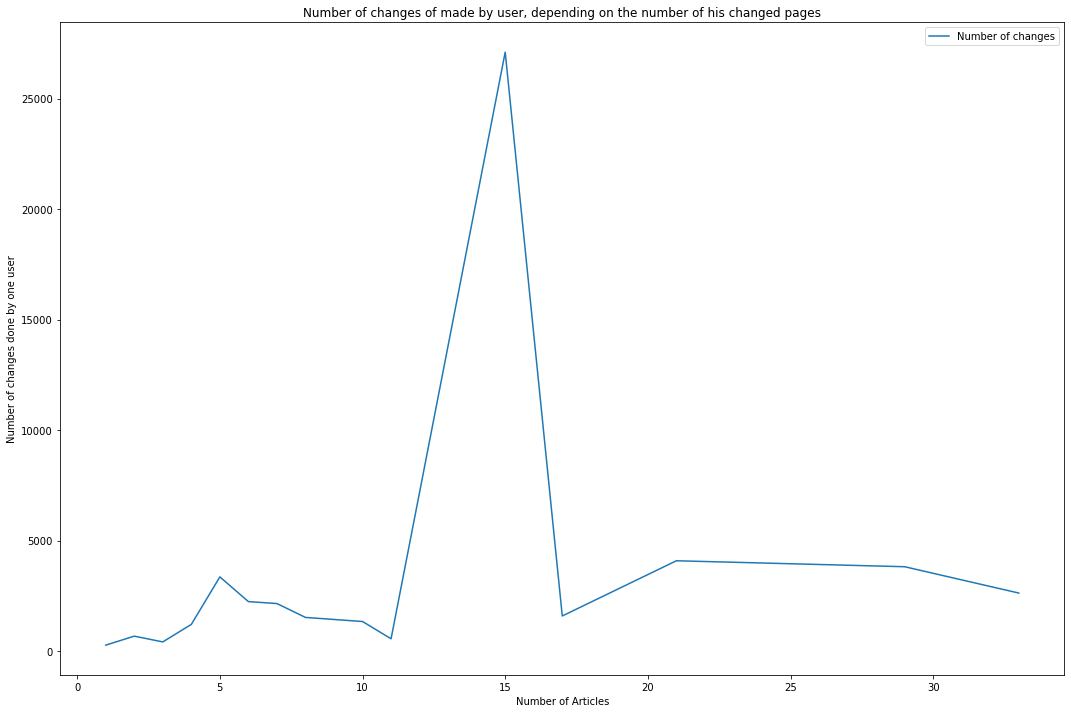

In [31]:
changes_table = pd.DataFrame(pysqldf('''
    SELECT AVG(number_of_changes) AS avg_number_of_changes,
           number_of_articles
    FROM sum_changes_table
    GROUP BY number_of_articles
    ORDER BY number_of_articles;
'''))

plt.rcParams["figure.figsize"] = (18, 12)

plt.subplot(1, 1, 1)
plt.plot(changes_table['number_of_articles'], changes_table['avg_number_of_changes'], label='Number of changes')
plt.title('Number of changes of made by user, depending on the number of his changed pages')
plt.xlabel('Number of Articles')
plt.ylabel('Number of changes done by one user')
plt.legend()

### Linear regression

There is a hypotesis that number of changes increases lineary over time.

In [43]:
date_with_changes = pd.DataFrame(pysqldf('''
    SELECT SUM(changes) AS number_of_changes,
           Date
    FROM db
    GROUP BY Date
    ORDER BY Date ASC;
'''))

date_with_changes

,number_of_changes,Date
0,71,2004-09-11 00:00:00.000000
1,44,2004-10-11 00:00:00.000000
2,931,2004-10-19 00:00:00.000000
3,42,2004-10-21 00:00:00.000000
4,24,2004-10-29 00:00:00.000000
...,...,...
454,1486,2008-12-03 00:00:00.000000
455,79,2008-12-04 00:00:00.000000
456,94,2008-12-05 00:00:00.000000
457,73,2008-12-06 00:00:00.000000


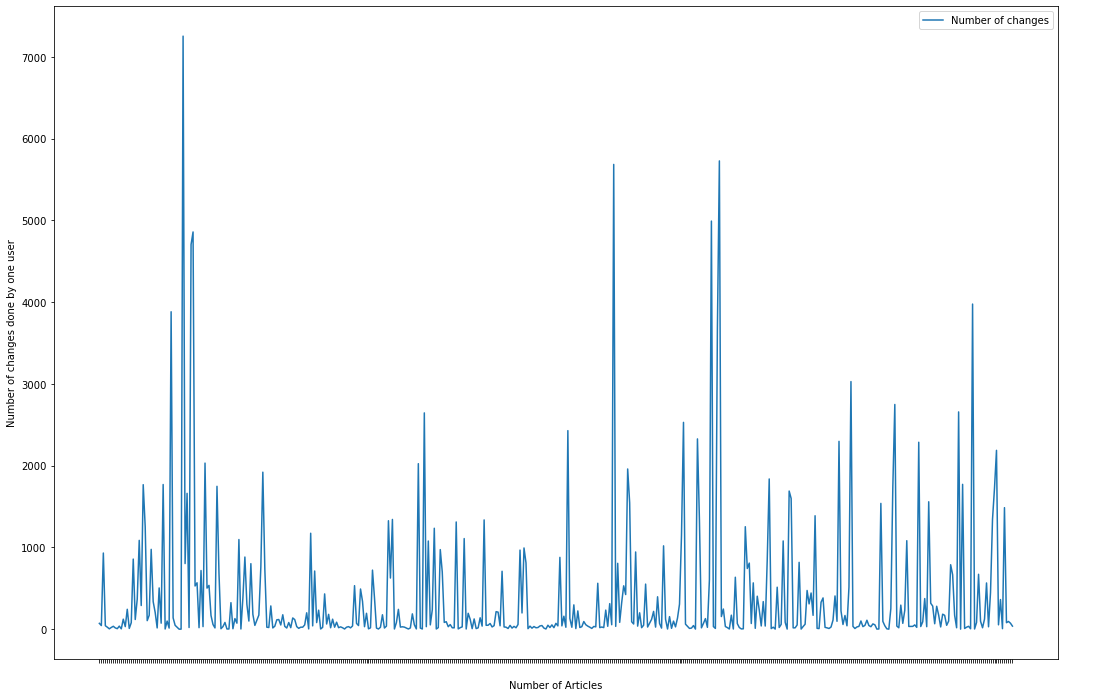

In [44]:
plt.rcParams["figure.figsize"] = (18, 12)

plt.subplot(1, 1, 1)
plt.plot(date_with_changes['Date'], date_with_changes['number_of_changes'], label='Number of changes')
plt.xlabel('Number of Articles')
plt.ylabel('Number of changes done by one user')
plt.xticks(color='w')
plt.legend()

As a result, seen from graphic, there is no linear regression between this two dimensions.


### Text analysis

Here we will analyze frequency of words and themes in titles of articles, and how they correlate with their changes and users of Wikepidea. 

In [50]:
!pip install wordcloud==1.8.0

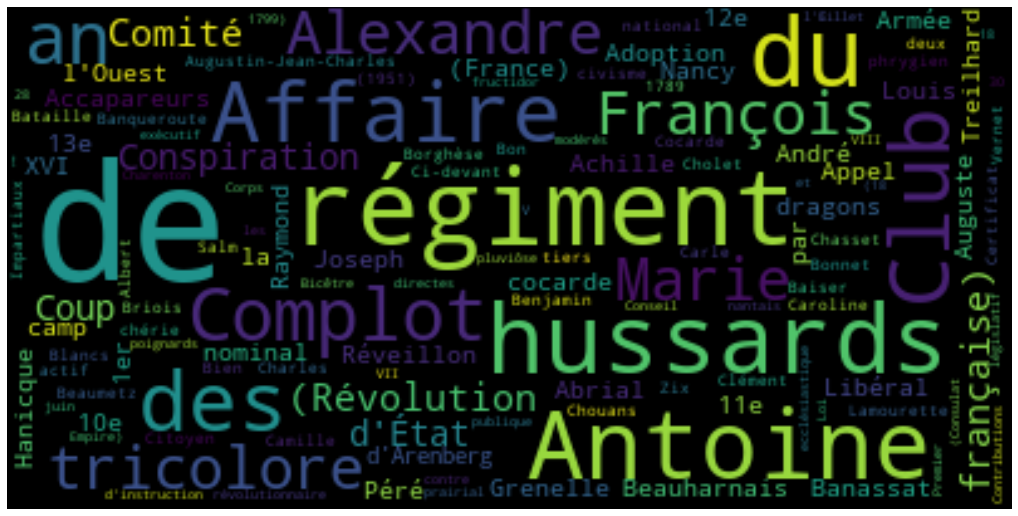

In [79]:
from wordcloud import WordCloud
from collections import Counter


def split_name(name):
    temp = name.split('_')
    if len(temp) > 1:
        result = ' '.join(temp)
        return result
    else:
        return temp[0]

    
text = ' '.join([split_name(x) for x in pysqldf('''SELECT Name 
                                                   FROM db 
                                                   GROUP BY Name;''')['Name']])
text = text.split()

wordDict = Counter(text)
word_cloud = WordCloud().generate_from_frequencies(wordDict)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()